#### GISC 420 T1 2022
# Making new geometries using uh... geometry

In [2]:
# You need to run this cell to get things setup
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot

import geopandas

import copy

# Load the datasets
pts = geopandas.read_file("pts.geojson")
lines = geopandas.read_file("ways.geojson")
bldgs = geopandas.read_file("buildings.geojson")

The most important thing to understand about the `geopandas` geometry operations is that most of them operate at the level of the geometry objects contained in a `GeoDataFrame`'s **geometry** attribute and produce a new `GeoSeries` rather than a new `GeoDataFrame`. That is, they make a collection of geometry objects, not a whole new dataset. 

This has implications for using these operations to create new datasets. You need to explicitly build the new dataset, as will be shown in this notebook.

## The `buffer` operation
For example, take the `buffer` operation. You can apply `buffer()` to a `GeoDataFrame` but it makes a new `GeoSeries` not a new `GeoDataFrame`

In [3]:
pts.buffer(10).head()

0    POLYGON ((1748147.727 5427473.896, 1748147.679...
1    POLYGON ((1747983.001 5427611.000, 1747982.953...
2    POLYGON ((1748160.360 5427495.275, 1748160.312...
3    POLYGON ((1747888.424 5427561.711, 1747888.376...
4    POLYGON ((1747812.896 5427729.783, 1747812.847...
dtype: geometry

You can also apply `buffer()` to a `GeoSeries`, and you'll get the same output as if you'd applied it to the `GeoDataFrame`

In [4]:
pts.geometry.buffer(10).head()

0    POLYGON ((1748147.727 5427473.896, 1748147.679...
1    POLYGON ((1747983.001 5427611.000, 1747982.953...
2    POLYGON ((1748160.360 5427495.275, 1748160.312...
3    POLYGON ((1747888.424 5427561.711, 1747888.376...
4    POLYGON ((1747812.896 5427729.783, 1747812.847...
dtype: geometry

To make a new `GeoDataFrame` which will include all the associated attributes and data, this means you have two options. One is to make a copy of the original and assign the buffered geometries to it.

In [5]:
# Make a copy of the original dataset
pts_b10 = copy.copy(pts)
# set the geometry of the copy to the result of performing
# some operation on the original dataset
pts_b10.geometry = pts.buffer(10)

To confirm we got what we expected, we can plot these as below.

<AxesSubplot:>

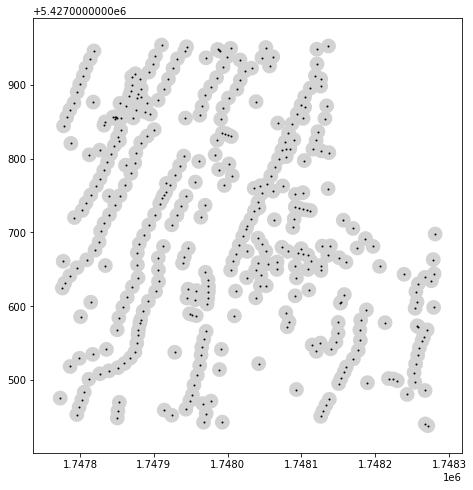

In [6]:
fig = pyplot.figure(figsize=(8,8))
base = fig.add_subplot(111)
pts_b10.plot(ax=base, facecolor='lightgrey')
pts.plot(ax=base, color='k', markersize=1)

And at this point, if we wished, we could write `pts_b10` to a new output file, if we wanted to keep it.

The other option is to reassign the geometry of the original dataset

In [7]:
pts.geometry = pts.buffer(10)

You have to be pretty sure this is what you want as now you have lost the original `pts` dataset!

In [8]:
pts.geometry.head()

0    POLYGON ((1748147.727 5427473.896, 1748147.679...
1    POLYGON ((1747983.001 5427611.000, 1747982.953...
2    POLYGON ((1748160.360 5427495.275, 1748160.312...
3    POLYGON ((1747888.424 5427561.711, 1747888.376...
4    POLYGON ((1747812.896 5427729.783, 1747812.847...
Name: geometry, dtype: geometry

Note that the geometry column now contains polygons! Let's just reset `pts` back to the data from the file, so we don't forget.

In [9]:
pts = geopandas.read_file("pts.geojson")

Either way you get all the attributes of the original dataset. 

If you only want some of them, you do something like this

In [10]:
pts_b10 = pts_b10[['full_id', 'osm_type', 'geometry']]
pts_b10.head()

,full_id,osm_type,geometry
0,n5633815123,node,"POLYGON ((1748147.727 5427473.896, 1748147.679..."
1,n5633815231,node,"POLYGON ((1747983.001 5427611.000, 1747982.953..."
2,n5633815230,node,"POLYGON ((1748160.360 5427495.275, 1748160.312..."
3,n5633815229,node,"POLYGON ((1747888.424 5427561.711, 1747888.376..."
4,n5633815218,node,"POLYGON ((1747812.896 5427729.783, 1747812.847..."


If you do this, you have to be careful to **ensure that the `geometry` attribute is one of the ones in the list that you ask to retain** in the dataset, otherwise your `GeoDataFrame` will become just a simple `DataFrame` and re-adding the geometry can be tricky.

Anyway, we can buffer lines and polygons too, when some other options may become relevant such as `cap_style` and `join_style`; see [the shapely documentation](https://shapely.readthedocs.io/en/latest/manual.html#constructive-methods) for details.

Perhaps more interesting, with polygons we can have negative buffer distances...

Text(0.5, 1.0, 'Eroded by 1m')

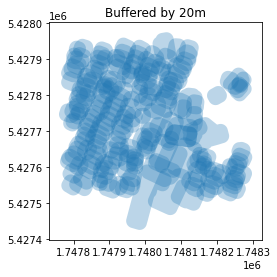

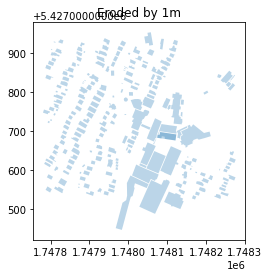

In [11]:
bldgs.buffer(20).plot(alpha=0.3).set_title("Buffered by 20m")
bldgs.buffer(-1).plot(alpha=0.3).set_title("Eroded by 1m")

I have found that a negative buffer that is too large produces errors, presumably because it attempts to shrink a polygon to less than nothing!

## `centroid`, `boundary`, `convex_hull` and `envelope`
Each of these produces convenient summary objects for the elements in a dataset.  It is important to note that these **are not functions** they are **attributes** of the `GeoDataFrame` and so they don't require parentheses when you request them.

<AxesSubplot:title={'center':'boundary'}>

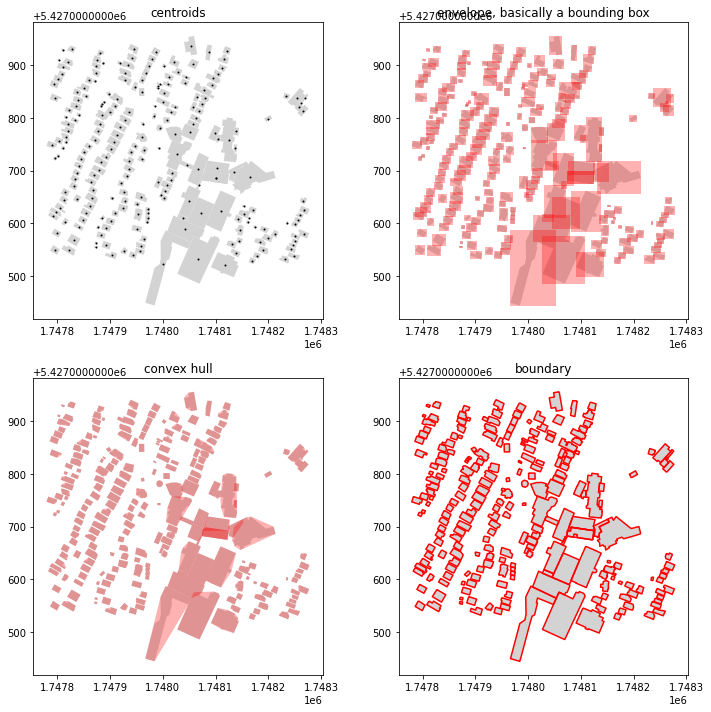

In [12]:
fig = pyplot.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.set_title("centroids")
bldgs.plot(ax=ax1, facecolor='lightgrey')
bldgs.centroid.plot(ax=ax1, markersize=1, color='k')

ax2 = fig.add_subplot(222)
ax2.set_title("envelope, basically a bounding box")
bldgs.plot(ax=ax2, facecolor='lightgrey')
bldgs.envelope.plot(ax=ax2, facecolor='r', alpha=0.3, linewidth=0)

ax3 = fig.add_subplot(223)
ax3.set_title("convex hull")
bldgs.plot(ax=ax3, facecolor='lightgrey')
bldgs.convex_hull.plot(ax=ax3, facecolor='r', alpha=0.3, linewidth=0)

# This one looks like it does nothing, but what it does is to 
# turn a polygon (filled) into a polyline (just an outline)
# Note how there is no facecolor specifed for this
ax4 = fig.add_subplot(224)
ax4.set_title("boundary")
bldgs.plot(ax=ax4, facecolor='lightgrey')
bldgs.boundary.plot(ax=ax4, edgecolor='r')

You can also merge all the geometries in a dataset into a single geometry (`unary_union`) and simplify the geometry of objects (`simplify()`). 

Try these in the cell below.